# Moving Box - Generalize for Boxes with Large Gap

In [62]:
from util import *
from util.parser import *
from util.img_kit import *
from util.notebook_display import *
from util.numeric_ops import *
from util.tf_ops import *

from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc
from os import walk
import os
import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Collect an ensemble of box data

In [63]:
img_collections = get_processed_moving_box_squares()
# number of images for each collection
num_per_collection = [x.shape[0] for x in img_collections]
# number of collections
n_collection = len(img_collections)
# total number of images
total_imgs = sum(num_per_collection)
print("\nAfter Augmentation: img_collections has {} collections, {} images in total".format(n_collection, total_imgs))

{'dim': (56, 32, 32), 'images:': 'bigSquare-vertical-2'}
{'dim': (56, 32, 32), 'images:': 'square-diagnal-2'}
{'dim': (56, 32, 32), 'images:': 'bigSquare-vertical'}
{'dim': (56, 32, 32), 'images:': 'bigSquare-diagnal-2'}
{'dim': (56, 32, 32), 'images:': 'square-vertical-2'}
{'dim': (56, 32, 32), 'images:': 'square-vertical-3'}
{'dim': (56, 32, 32), 'images:': 'bigSquare-vertical-3'}
{'dim': (56, 32, 32), 'images:': 'bigSquare-diagnal'}
{'dim': (56, 32, 32), 'images:': 'square-diagnal'}

After Augmentation: img_collections has 9 collections, 504 images in total


In [64]:
test_file = "data/moving-box/processed/Box/test/square-vertical.npz"
test_imgs = load_imgs(test_file)

{'dim': (56, 32, 32), 'images:': 'square-vertical'}


## Sample Train and Dev

In [65]:
def sample(batch_size = 8, train=True, gap = 1):
    train_ind_collection, val_ind_collection = zip(*[split_train_dev(x) for x in img_collections])
    # get average number of training for each class
    avg_num_per_class = int(np.ceil(batch_size/n_collection))
    # before-index for each class
    before_ind = []
    for i in range(n_collection):
        data = train_ind_collection[i] if train else val_ind_collection[i]
        try:
            s = np.random.choice(list(filter(lambda x:x<num_per_collection[i]-gap-1, data)),avg_num_per_class, replace=False)
            before_ind.append(s)
        except:
            before_ind.append(np.array([]))
    # after-index for each class
    after_ind = [x+gap+1 for x in before_ind]
    # mid-index for each class
    mid_ind = [x+(gap+1)//2 for x in before_ind]
    
    selected_classed = [i for i in range(n_collection) if before_ind[i].shape[0]>0]
    before_imgs = np.concatenate([img_collections[i][before_ind[i]] for i in selected_classed], axis = 0)
    after_imgs = np.concatenate([img_collections[i][after_ind[i]] for i in selected_classed], axis = 0)
    mid_imgs = np.concatenate([img_collections[i][mid_ind[i]] for i in selected_classed], axis = 0)
    
    clipped = np.random.choice(range(before_imgs.shape[0]), batch_size, replace=False)
    before_imgs = before_imgs[clipped]
    mid_imgs = mid_imgs[clipped]
    after_imgs = after_imgs[clipped]
    return (before_imgs, after_imgs), mid_imgs


def sample_train(batch_size = 8, gap = 1): return sample(batch_size, gap = gap)


def sample_dev(batch_size = 8, gap = 1):  return sample(batch_size, False, gap)

## Sample Test

In [66]:
def sample_test(batch_size = 8, gap = 1):  
    return sample_pred_frames(test_imgs, gap, batch_size)

## Take a look at Training data

Before: (8, 32, 32)
After:  (8, 32, 32)
Mid:    (8, 32, 32)


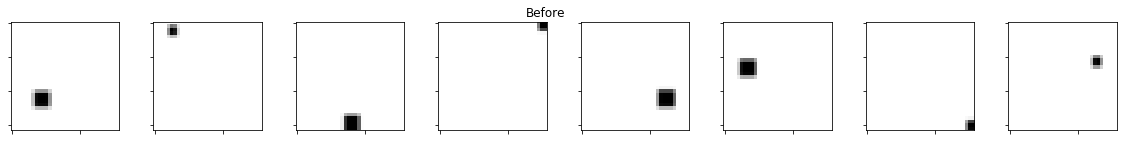

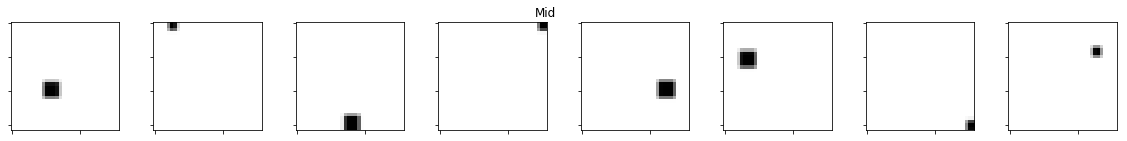

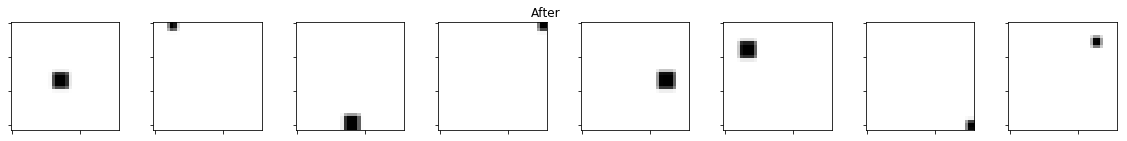

In [67]:
(test_before, test_after), test_mid = sample_train(batch_size=8, gap=5)
print("Before: {}".format(test_before.shape))
print("After:  {}".format(test_after.shape))
print("Mid:    {}".format(test_mid.shape))
size = (20, 2)
plot_images(test_before, size, "Before")
plot_images(test_mid, size, "Mid")
plot_images(test_after, size, "After")

## Sample of Test Data

Before: (8, 32, 32)
After:  (8, 32, 32)
Mid:    (8, 32, 32)


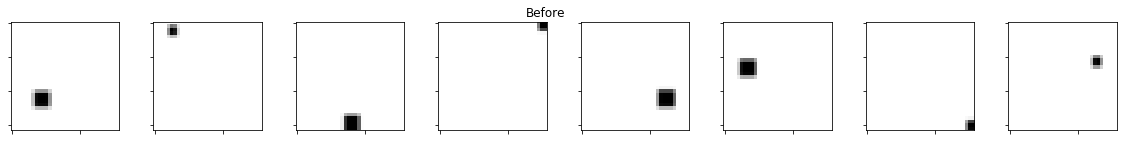

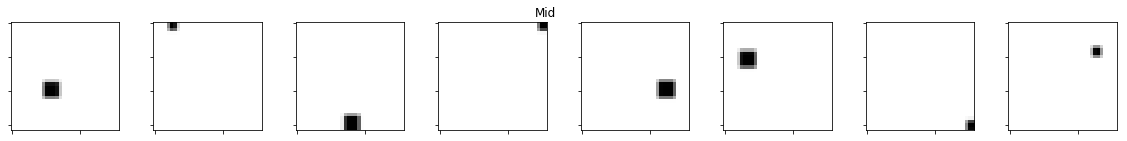

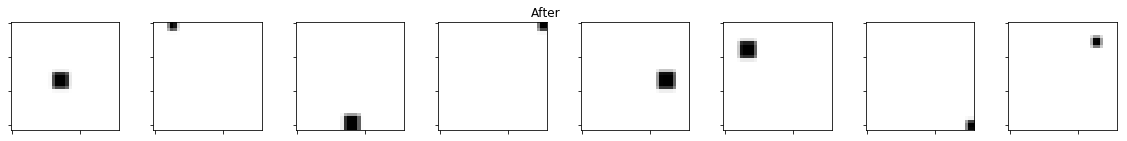

In [68]:
before, after, mid = sample_test(batch_size=8, gap=5)
print("Before: {}".format(test_before.shape))
print("After:  {}".format(test_after.shape))
print("Mid:    {}".format(test_mid.shape))
size = (20, 2)
plot_images(test_before, size, "Before")
plot_images(test_mid, size, "Mid")
plot_images(test_after, size, "After")

# Model

### Loss

In [69]:
def content_loss(x, gd):
    x, gd = tf.contrib.layers.flatten(x), tf.contrib.layers.flatten(gd)
    return tf.norm(x-gd)

## Generator

In [102]:
def generate(x1, x2,  is_training=True):
    """
    Input:
        x1, x2: batch size of images for inference
    Output:
        predicted images of batch size
    """
    with tf.variable_scope("generator") as scope:
        # reshape and concatenate
        x1 = tf.reshape(x1, [-1,  32, 32, 1])
        x2 = tf.reshape(x2, [-1,  32, 32, 1])
        x = tf.concat([(x1+x2)/2, (x2-x1)], axis=3)
        
        x = tf.layers.conv2d(x, filters = 6, kernel_size=8, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, axis=3, training=is_training)
        
        x = tf.layers.conv2d(x, filters = 8, kernel_size=6, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, axis=3, training=is_training)
        
        x = tf.layers.conv2d(x, filters = 16, kernel_size=3, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, axis=3, training=is_training)
        
        x = tf.layers.conv2d(x, filters = 32, kernel_size=2, padding='same', activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, axis=3, training=is_training)
        
        x = tf.layers.conv2d(x, filters = 64, kernel_size=2, padding='same', activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, axis=3, training=is_training)
        
        x = tf.layers.conv2d(x, filters = 128, kernel_size=2, padding='same', activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, axis=3, training=is_training)
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, 1024, activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, training=is_training)
        
        x = tf.layers.dense(x, 8*8*128, activation=tf.nn.relu)
        x = tf.reshape(x, [-1, 8, 8, 128])
        
        x = tf.layers.conv2d(x, filters = 32, kernel_size=2, padding='same', activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, axis=3, training=is_training)
        
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.relu, padding='same')
        x = tf.layers.batch_normalization(x,  axis=3, training=is_training)
        
        img = tf.layers.conv2d_transpose(x, filters=1, kernel_size=(4, 4),  strides=(2, 2), activation=tf.nn.tanh, padding='same')
        img = tf.reshape(img, [-1, 32, 32, 1])
        return img

### Get a Batch Generation

In [103]:
def get_generattion(before, after, mid):
    dic = {batch_before: before, batch_after: after, batch_mid: mid, is_training: False}
    gen_batch = sess.run(G_batch, dic)
    return gen_batch

### Solver

In [104]:
def get_solver(learning_rate=1e-3, beta1=0.5):
    return tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)

## Param

In [105]:
gap = 3
batch_size = 32

learning_rate = 8e-5
beta = 0.9 # defalut 0.9 for adam
num_iteration = 4000
relu_alpha = 0.01

### Report Loss = loss_computed * 255 / batch_size

In [106]:
def report_loss(before, after, mid, num_run = 1000):
    dic = {batch_before: before, batch_after: after, batch_mid: mid, is_training: False}
    return np.mean([sess.run(G_loss, dic) for _ in range(num_run)]) / batch_size * 255

## Computational Graph

In [107]:
tf.reset_default_graph()
batch_mid        = tf.placeholder(tf.float32, [None, 32, 32])
batch_before     = tf.placeholder(tf.float32, [None, 32, 32])
batch_after      = tf.placeholder(tf.float32, [None, 32, 32])
is_training      = tf.placeholder(tf.bool, ())

G_batch = generate(batch_before, batch_after)

G_loss = content_loss(G_batch, batch_mid)
G_solver = get_solver(learning_rate, beta)

G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

In [108]:
def train(sess, G_step, G_loss, batch_size, num_iteration, plot_every = 400, show_loss_every=400, nPlot=6):
    g_losses = []
    for i in range(num_iteration):
        (real_before, real_after), real_mid = sample_train(batch_size, gap)
        dic = {batch_mid: real_mid, batch_before: real_before, batch_after: real_after, is_training: True}
        _, G_loss_curr = sess.run([G_train_step, G_loss], dic)
        
        g_losses.append(G_loss_curr)
        if i%show_loss_every ==0:
            print("Iteration {}:  G_loss = {}".format(i, G_loss_curr))
            
        if i%plot_every == 0:
            gen_batch_test = sess.run(G_batch, feed_dict=\
                                      {batch_before: real_before, batch_after: real_after, is_training: False})
            plot_batch_images(gen_batch_test[:nPlot], (16, 2) , "Iteration: {}".format(i))
    return g_losses

# Train !

Iteration 0:  G_loss = 201.40225219726562


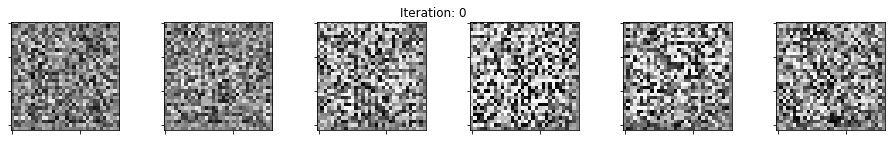

Iteration 100:  G_loss = 131.89630126953125
Iteration 200:  G_loss = 101.94181060791016
Iteration 300:  G_loss = 72.89141082763672
Iteration 400:  G_loss = 48.23259353637695
Iteration 500:  G_loss = 25.800830841064453


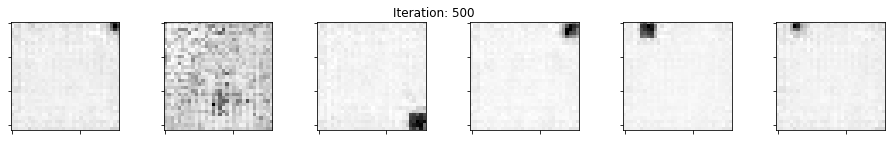

Iteration 600:  G_loss = 17.767484664916992
Iteration 700:  G_loss = 13.778519630432129
Iteration 800:  G_loss = 10.459677696228027
Iteration 900:  G_loss = 9.210122108459473
Iteration 1000:  G_loss = 7.367918968200684


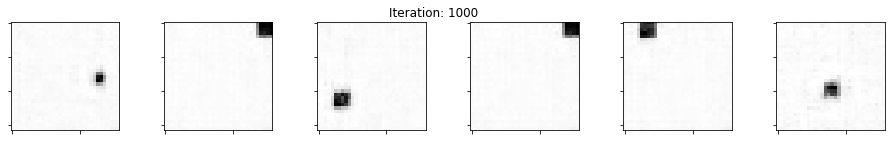

Iteration 1100:  G_loss = 6.847134113311768
Iteration 1200:  G_loss = 5.682210445404053
Iteration 1300:  G_loss = 5.286609649658203
Iteration 1400:  G_loss = 5.059418678283691
Iteration 1500:  G_loss = 4.607572555541992


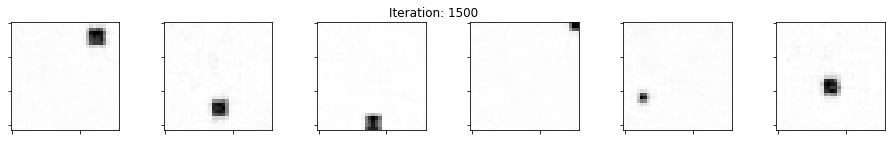

Iteration 1600:  G_loss = 4.186825752258301
Iteration 1700:  G_loss = 3.4994170665740967
Iteration 1800:  G_loss = 3.6241440773010254
Iteration 1900:  G_loss = 3.5672221183776855
Iteration 2000:  G_loss = 3.1422626972198486


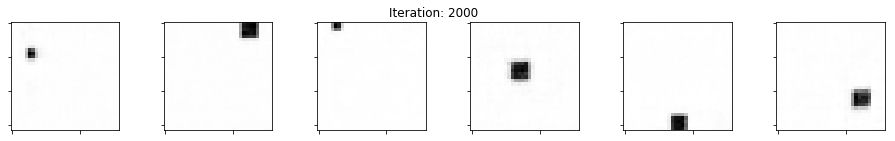

Iteration 2100:  G_loss = 3.3196921348571777
Iteration 2200:  G_loss = 3.0835626125335693
Iteration 2300:  G_loss = 2.915369987487793
Iteration 2400:  G_loss = 2.801933765411377
Iteration 2500:  G_loss = 2.717965602874756


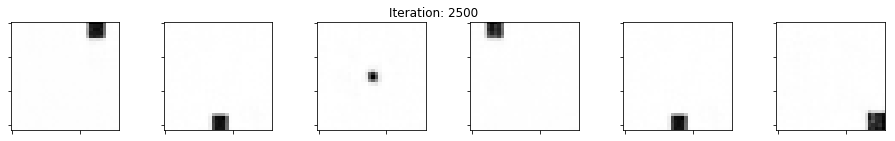

Iteration 2600:  G_loss = 2.7680745124816895
Iteration 2700:  G_loss = 2.66499924659729
Iteration 2800:  G_loss = 2.285391330718994
Iteration 2900:  G_loss = 2.2868876457214355
Iteration 3000:  G_loss = 1.9080673456192017


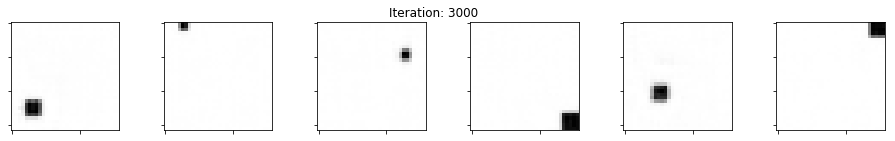

Iteration 3100:  G_loss = 2.1714706420898438
Iteration 3200:  G_loss = 2.049691915512085
Iteration 3300:  G_loss = 3.027183771133423
Iteration 3400:  G_loss = 2.405026912689209
Iteration 3500:  G_loss = 1.9721167087554932


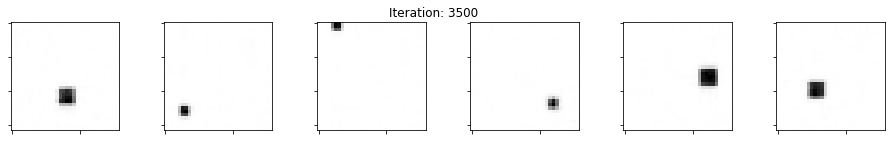

Iteration 3600:  G_loss = 1.7944025993347168
Iteration 3700:  G_loss = 1.8634177446365356
Iteration 3800:  G_loss = 1.99873948097229
Iteration 3900:  G_loss = 1.87456214427948


In [109]:
sess = get_session()
sess.run(tf.global_variables_initializer())
g_loss = train(sess, G_train_step, G_loss, batch_size, num_iteration, plot_every = 500, show_loss_every = 100)

## Plot of Learning Curve

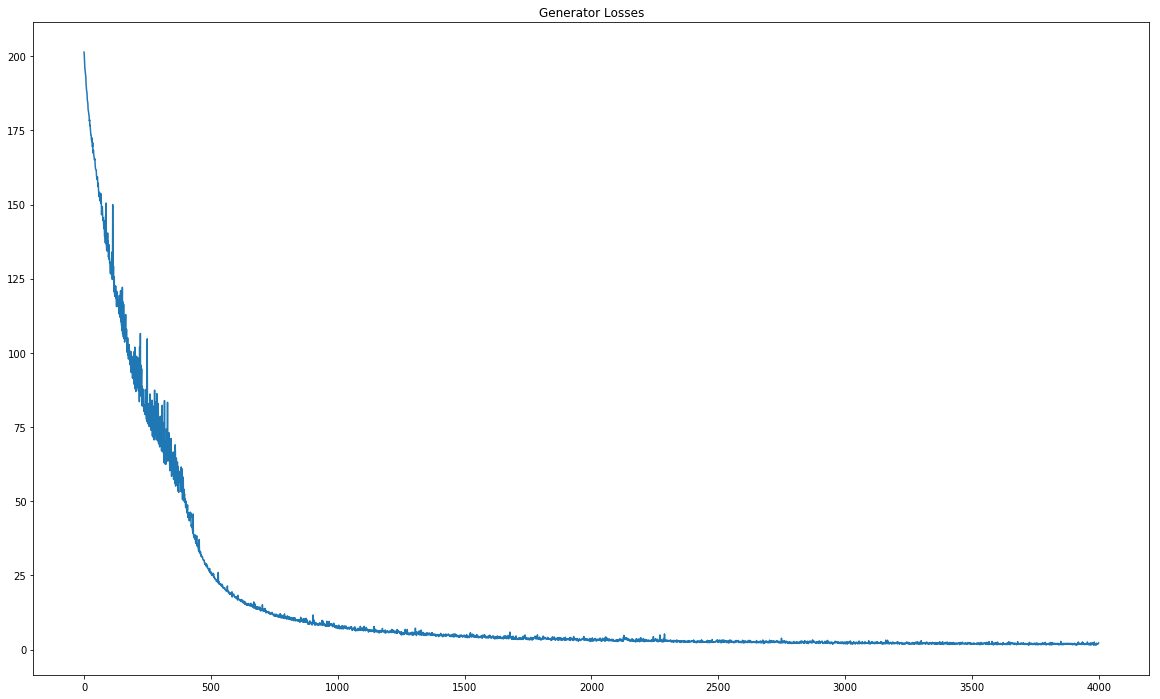

In [110]:
figsize = (20, 12)

plt.figure(figsize=figsize)
plt.plot(g_loss)
plt.title("Generator Losses")
plt.show()

## - Evaluate on Training Data

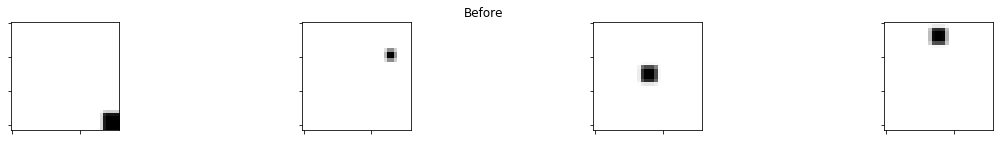

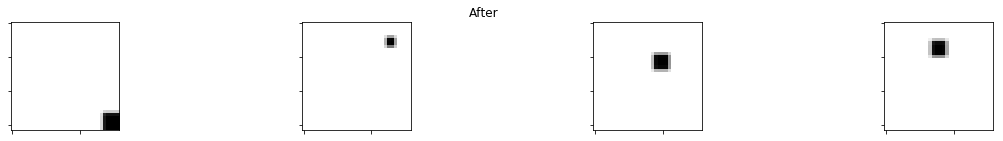

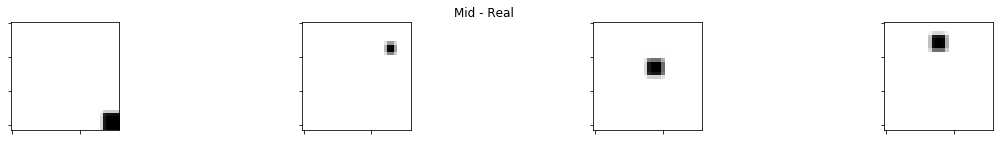

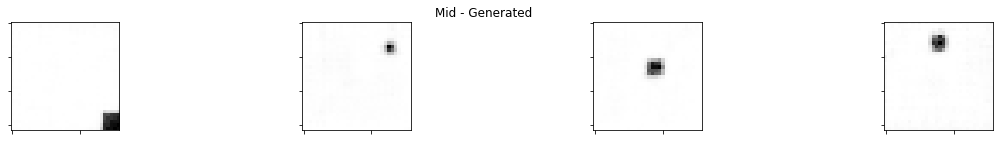

Training Loss = 25.138725265860558


In [114]:
def eval_train(num=4, gap = 3):
    (before, after), mid = sample_train(num, gap)
    gen_batch = get_generattion(before, after, mid)
    size = (20, 2)
    plot_images(before, size, "Before")
    plot_images(after, size, "After")
    plot_images(mid, size, "Mid - Real")
    plot_images(gen_batch, size, "Mid - Generated")
    
    loss = report_loss(before, after, mid)
    print("Training Loss = {}".format(loss))

eval_train()

## - Evaluate on Validation Data

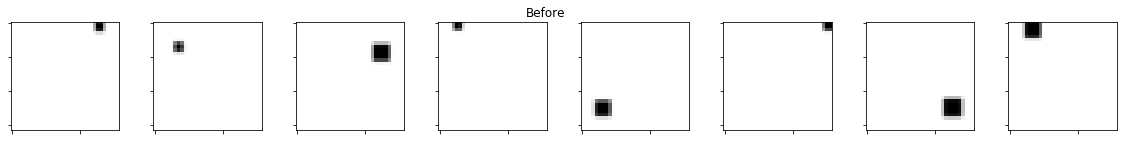

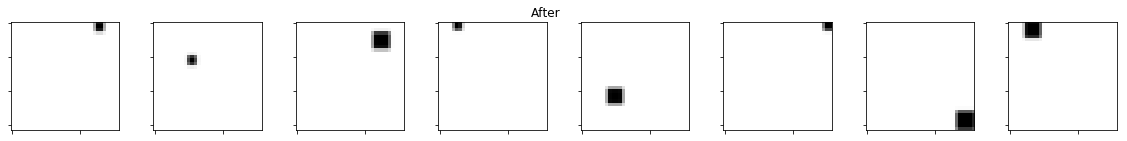

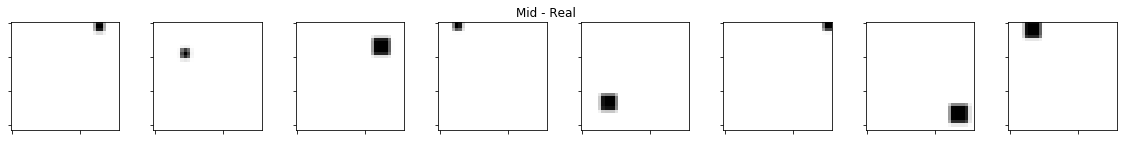

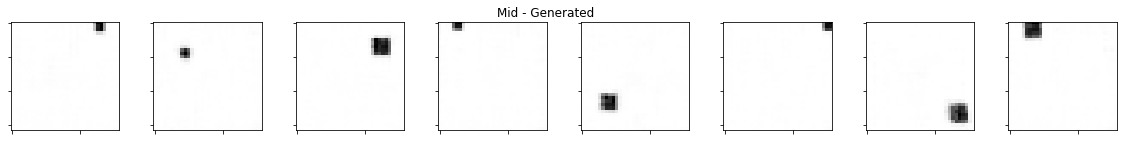

Validation Loss = 12.766110375523567


In [115]:
def test_unseens(num = 4, gap = 1, num_test = 1000):
    (before, after), mid = sample_dev(num, gap)
    gen_batch = get_generattion(before, after, mid)
    size = (20, 2)
    plot_images(before, size, "Before")
    plot_images(after, size, "After")
    plot_images(mid, size, "Mid - Real")
    plot_images(gen_batch, size, "Mid - Generated")
    
    loss = report_loss(before, after, mid)
    print("Validation Loss = {}".format(loss))

test_unseens(num = 8, gap = 3)

## - Evaluate on Test Data

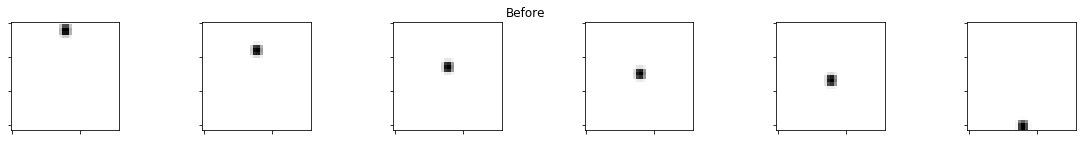

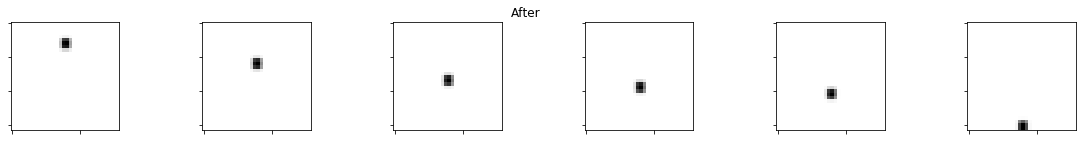

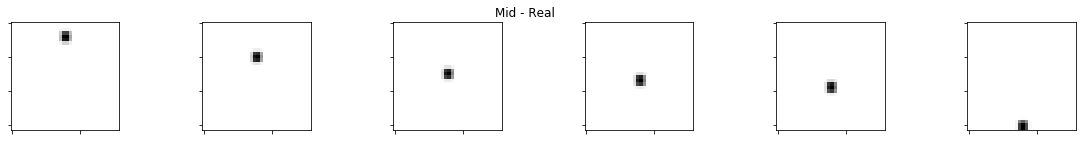

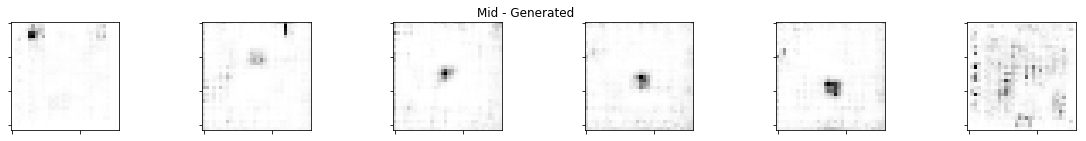

Test Loss = 40.79718343913555


In [113]:
def test(num = 6, gap = 3):
    before, after, mid = sample_test(num, gap)
    gen_batch = get_generattion(before, after, mid)
    size = (20, 2)
    plot_images(before, size, "Before")
    plot_images(after, size, "After")
    plot_images(mid, size, "Mid - Real")
    plot_images(gen_batch, size, "Mid - Generated")
    
    loss = report_loss(before, after, mid)
    print("Test Loss = {}".format(loss))

test()